In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import json
from functools import partial
import pathlib
import glob
from tqdm.notebook import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd

In [3]:
import jax
import jax.numpy as jnp
import equinox as eqx

In [4]:
from mc2.data_management import MaterialSet, EXPERIMENT_LOGS_ROOT, MODEL_DUMP_ROOT, load_data_into_pandas_df
from mc2.features.features_jax import compute_fe_single
from mc2.models.NODE import HiddenStateNeuralEulerODE
from mc2.models.model_interface import NODEwInterface, load_model
from mc2.metrics import evaluate_model, evaluate_model_on_test_set

In [5]:
def featurize(norm_B_past, norm_H_past, norm_B_future, temperature):
    past_length = norm_B_past.shape[0]
    future_length = norm_B_future.shape[0]

    featurized_B = compute_fe_single(jnp.hstack([norm_B_past, norm_B_future]), n_s=10)

    return featurized_B[past_length:]

In [6]:
data_dict = load_data_into_pandas_df(material="3C90")
mat_set = MaterialSet.from_pandas_dict(data_dict)
mat_set = mat_set.subsample(5)
train_set, val_set, test_set = mat_set.split_into_train_val_test(
    train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=12
)
train_set_norm = train_set.normalize(transform_H=True, featurize=featurize)
normalizer = train_set_norm.normalizer

Loading data for 3C90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.60it/s]
INFO:2025-08-11 10:31:23,338:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-08-11 10:31:23 | INFO : Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-08-11 10:31:23,339:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-08-11 10:31:23 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [7]:
exp_id = "84a49924-d6e0-4e"

In [8]:
interfaced_model = NODEwInterface(
    load_model(MODEL_DUMP_ROOT / f"{exp_id}.eqx", model_class=HiddenStateNeuralEulerODE),
    normalizer=normalizer,
    featurize=featurize,
)

In [9]:
norm_test_set = test_set.normalize(normalizer)

In [10]:
eval_metrics = evaluate_model_on_test_set(
    interfaced_model,
    test_set,
)
eval_metrics

{50000.0: {10: {'bh': {'energy_loss': -0.35887423157691956},
   'h': {'MAE': 6.467808723449707,
    'MSE': 424.59326171875,
    'WCE': 9.96911334991455}},
  720: {'bh': {'energy_loss': 10.467033386230469},
   'h': {'MAE': 54.97417068481445,
    'MSE': 8257.3544921875,
    'WCE': 228.5870361328125}},
  1430: {'bh': {'energy_loss': nan},
   'h': {'MAE': nan, 'MSE': nan, 'WCE': nan}},
  2141: {'bh': {'energy_loss': nan},
   'h': {'MAE': nan, 'MSE': nan, 'WCE': nan}},
  2851: {'bh': {'energy_loss': nan},
   'h': {'MAE': nan, 'MSE': nan, 'WCE': nan}},
  3562: {'bh': {'energy_loss': nan},
   'h': {'MAE': nan, 'MSE': nan, 'WCE': nan}},
  4272: {'bh': {'energy_loss': nan},
   'h': {'MAE': nan, 'MSE': nan, 'WCE': nan}},
  4983: {'bh': {'energy_loss': nan},
   'h': {'MAE': nan, 'MSE': nan, 'WCE': nan}},
  5693: {'bh': {'energy_loss': nan},
   'h': {'MAE': nan, 'MSE': nan, 'WCE': nan}},
  6404: {'bh': {'energy_loss': nan},
   'h': {'MAE': nan, 'MSE': nan, 'WCE': nan}}},
 80000.0: {10: {'bh': {'en

# plots:

In [11]:
from mc2.utils.data_plotting import plot_single_sequence, plot_hysteresis

In [12]:
data = test_set.at_frequency(80_000)

H_pred = interfaced_model(
    data.B[:10, :10],
    data.H[:10, :10],
    data.B[:10, 10:500],
    data.T[:10]
)

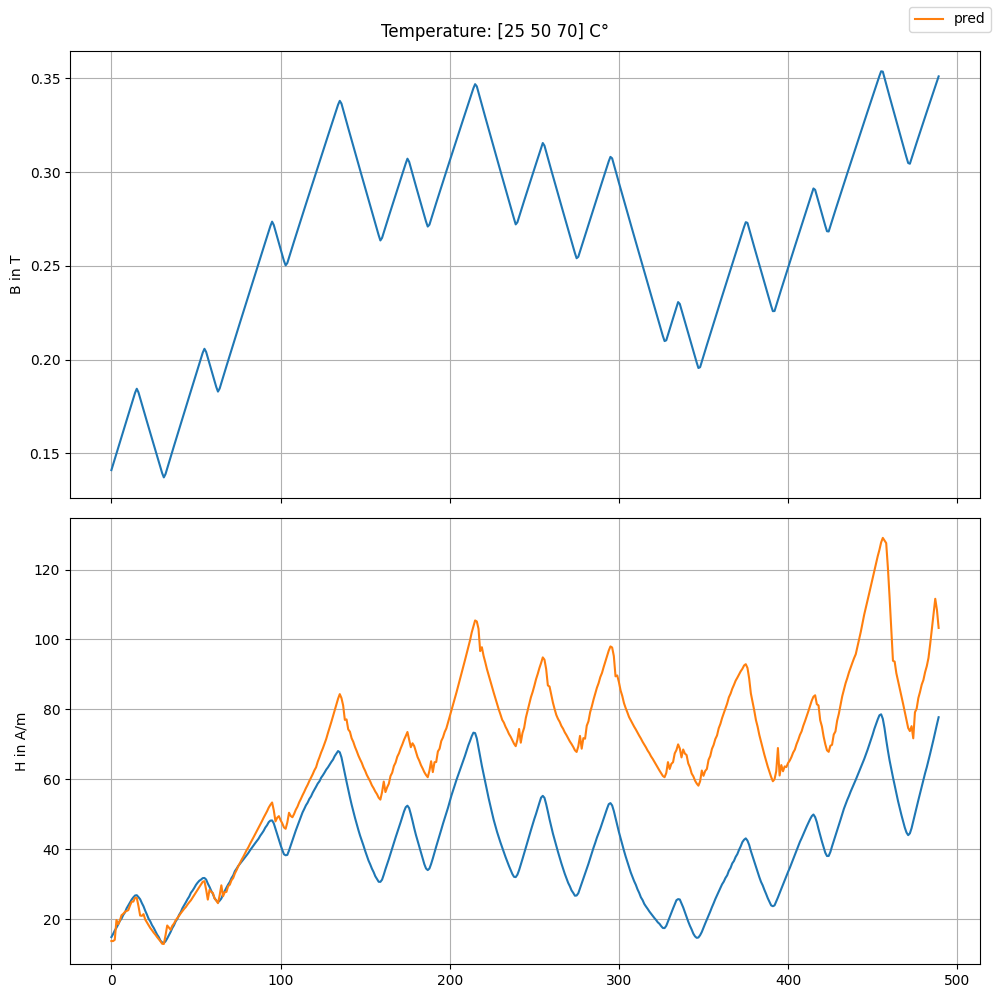

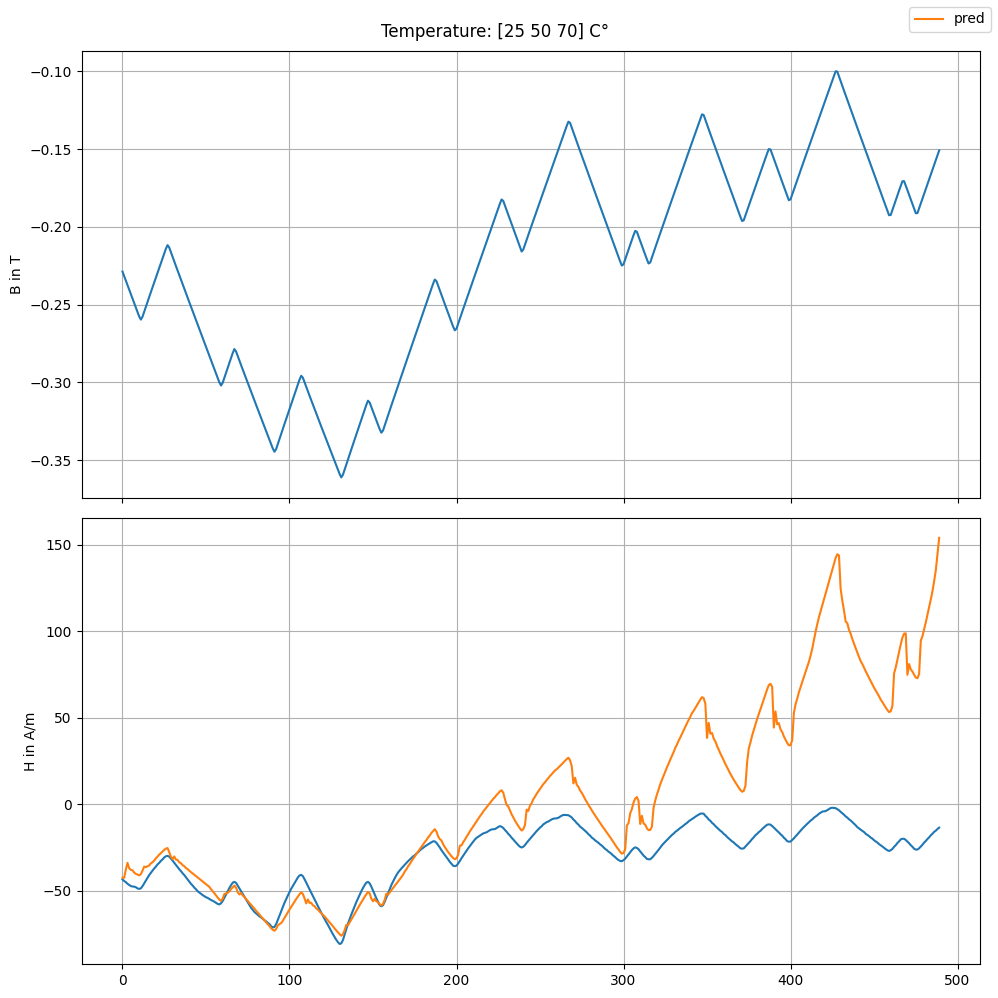

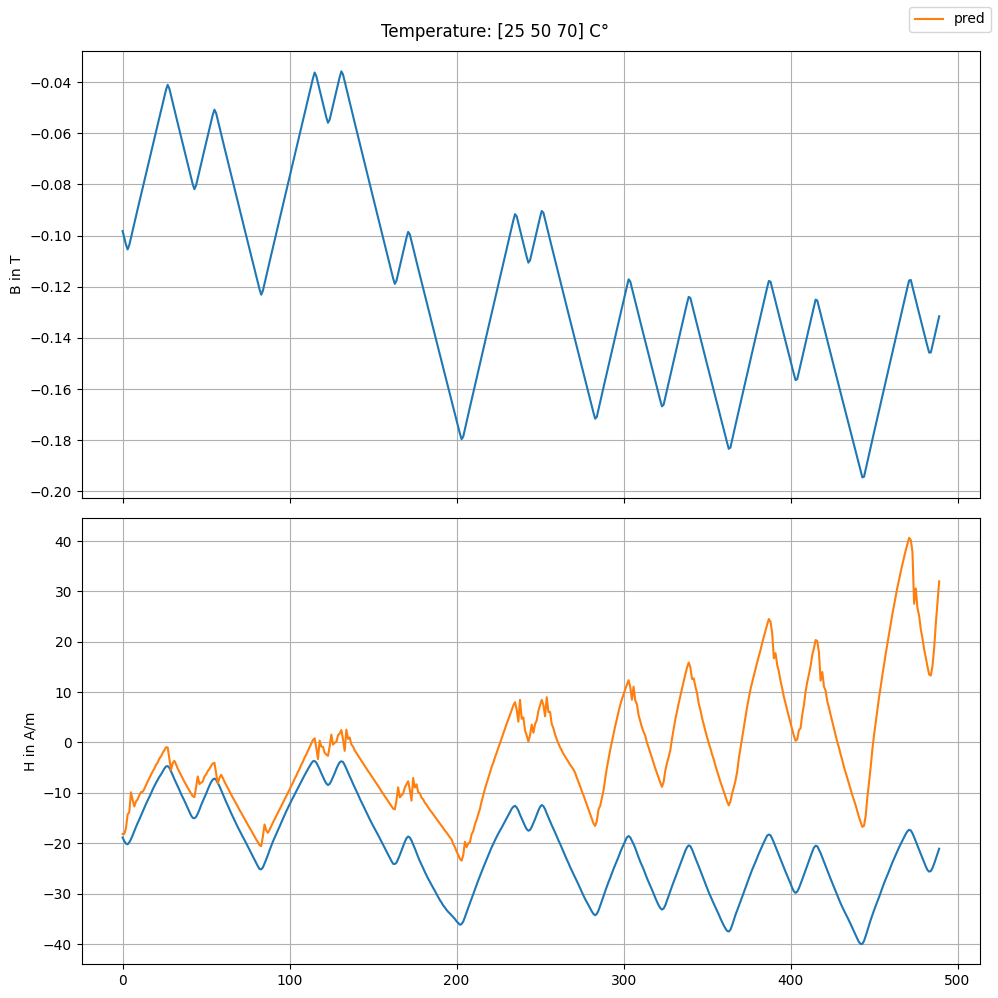

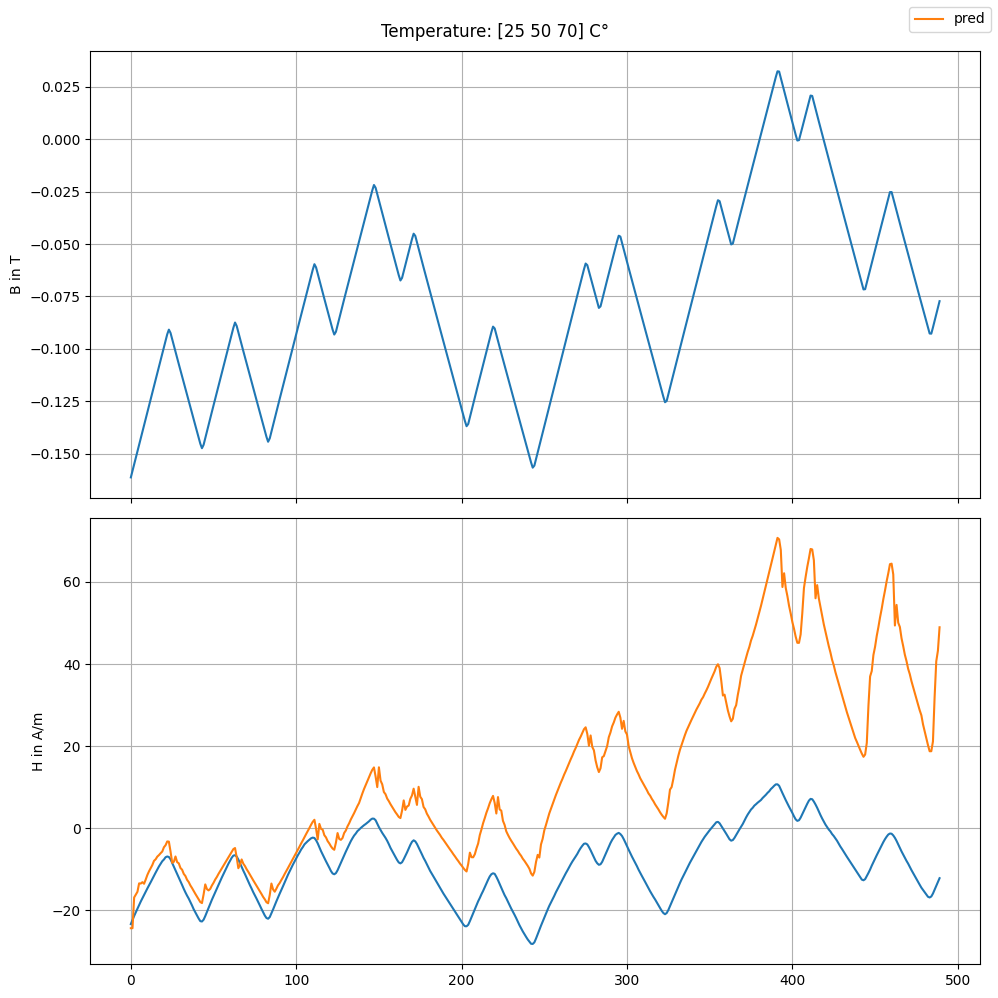

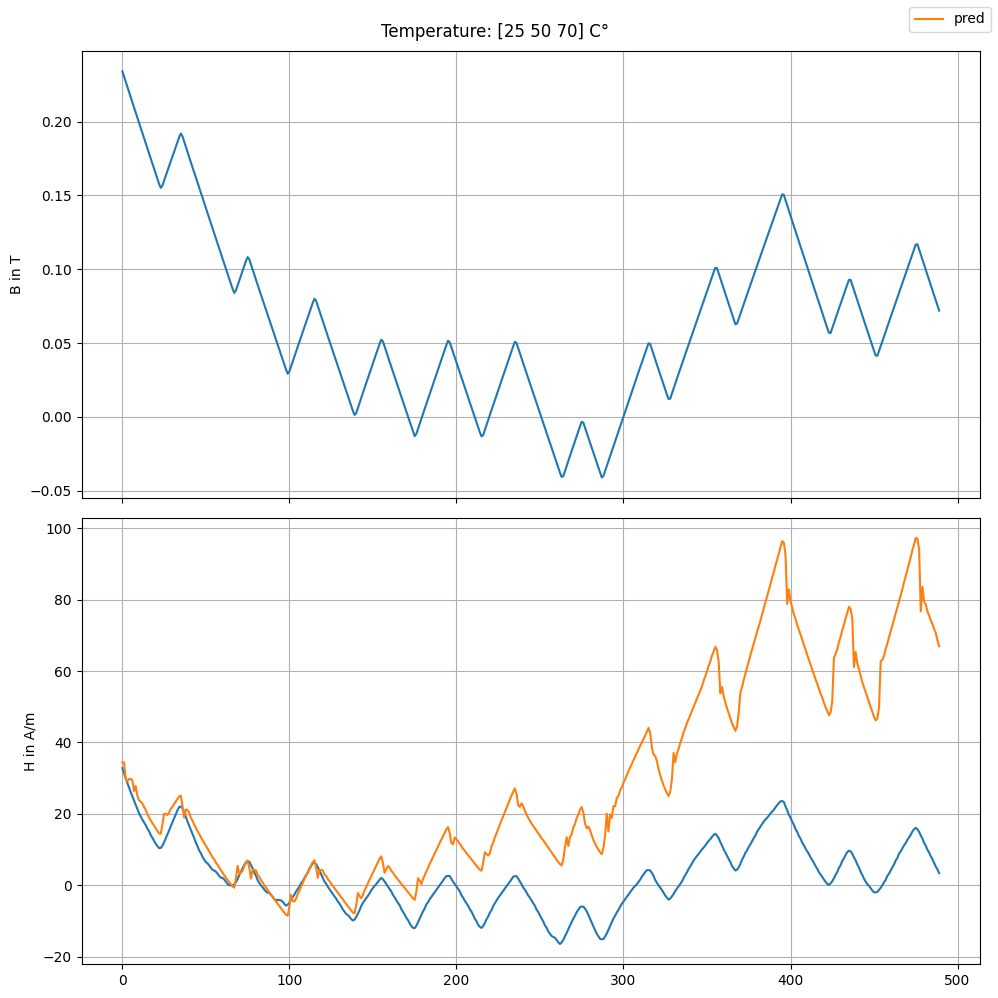

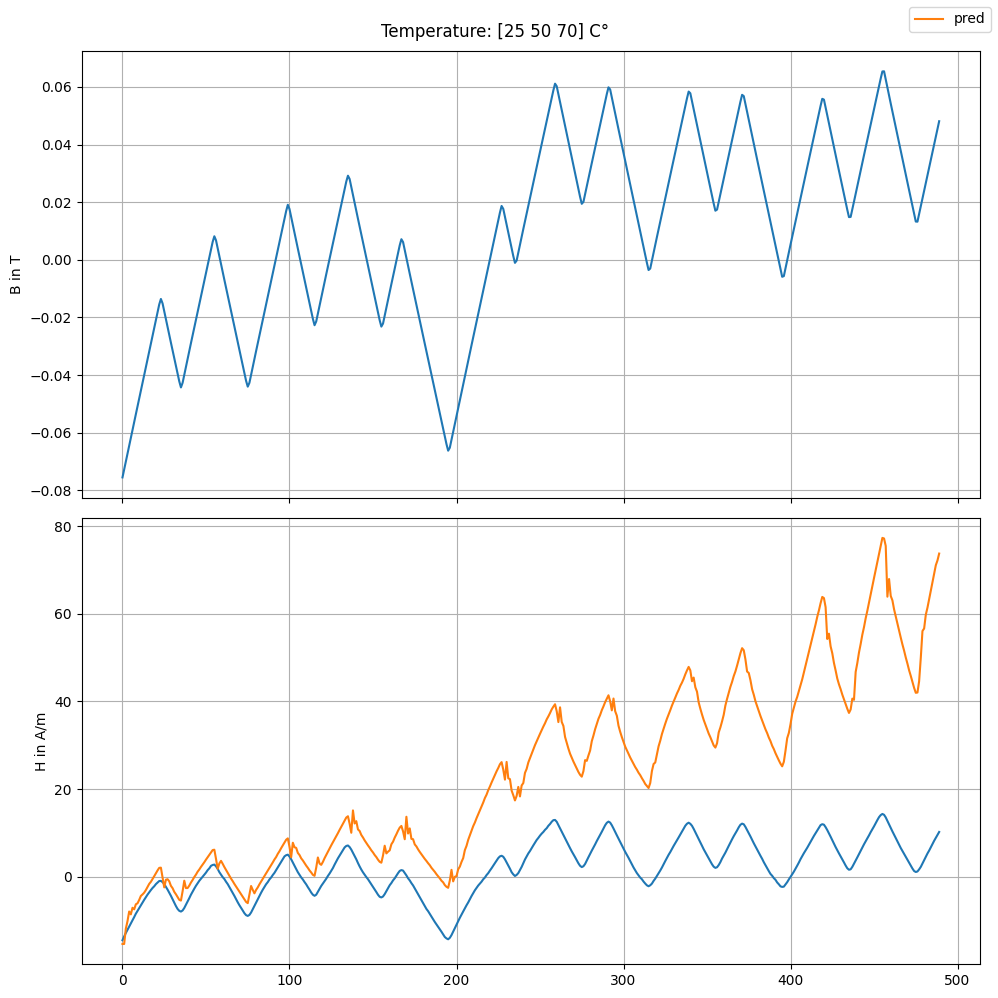

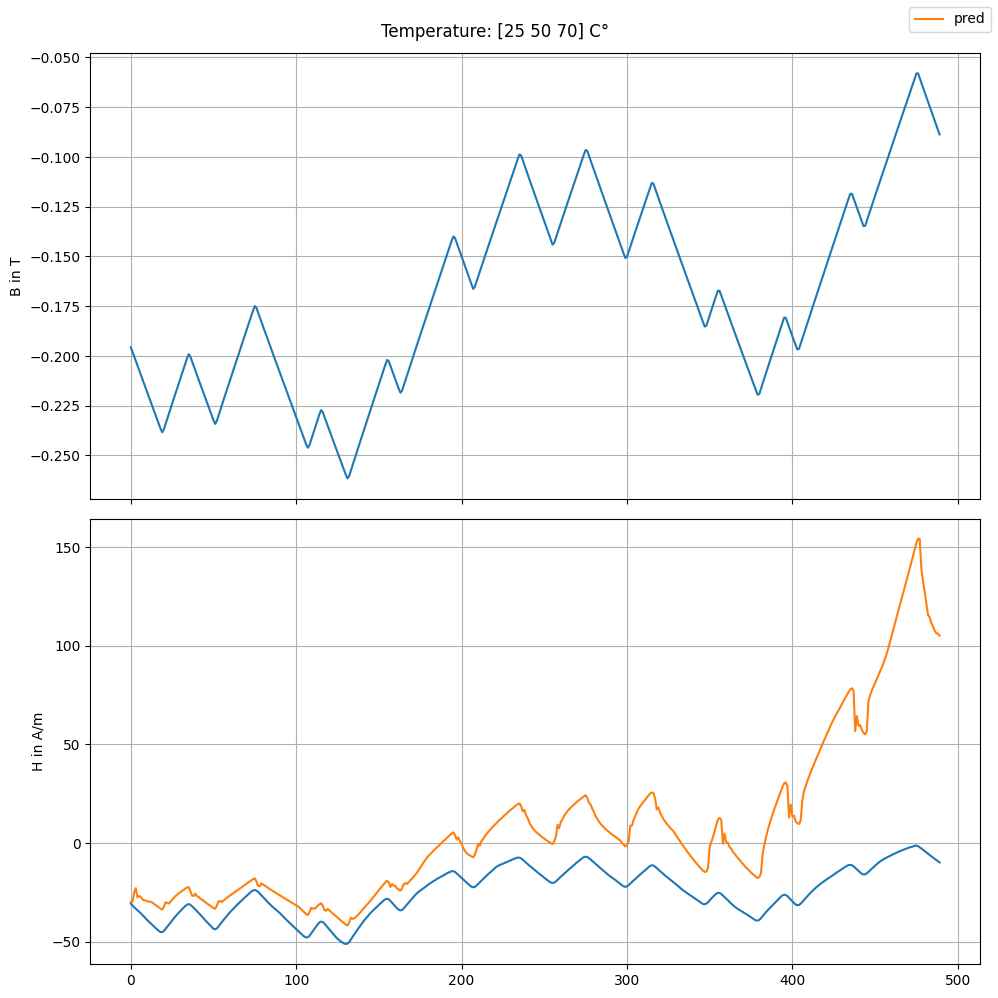

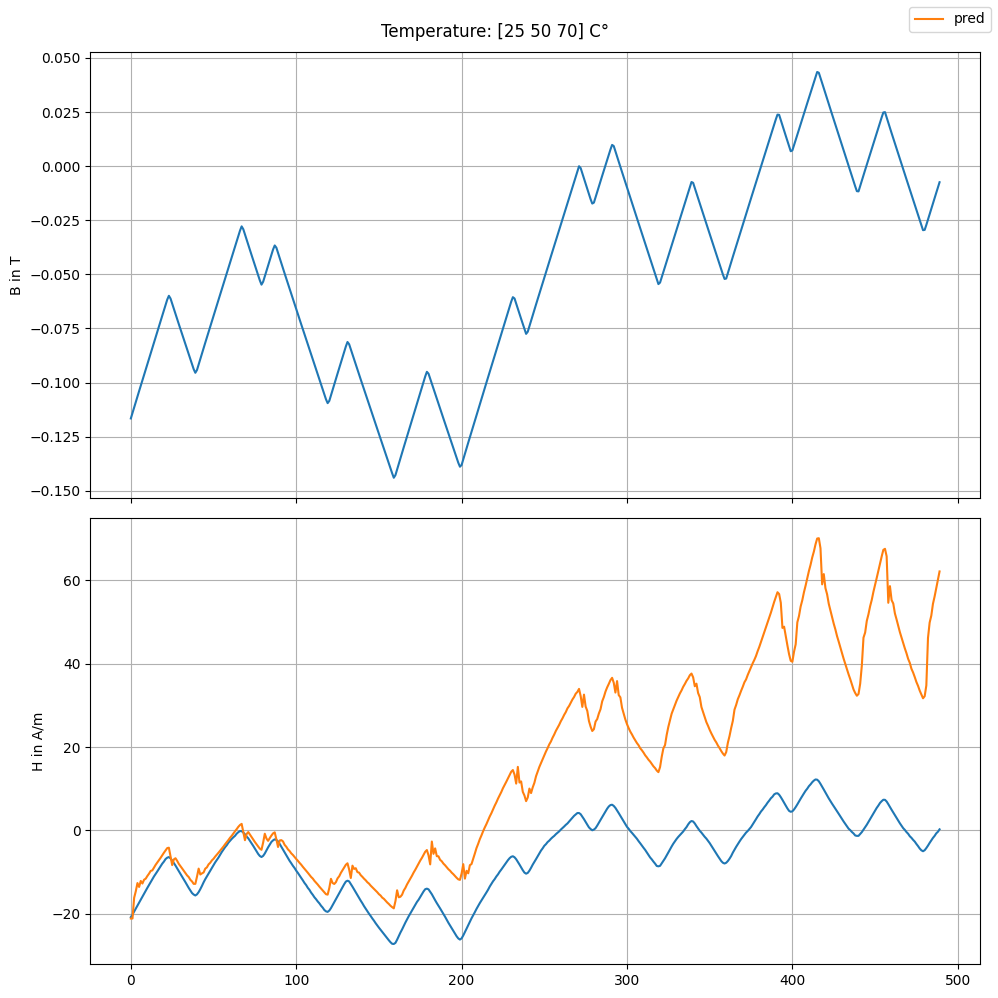

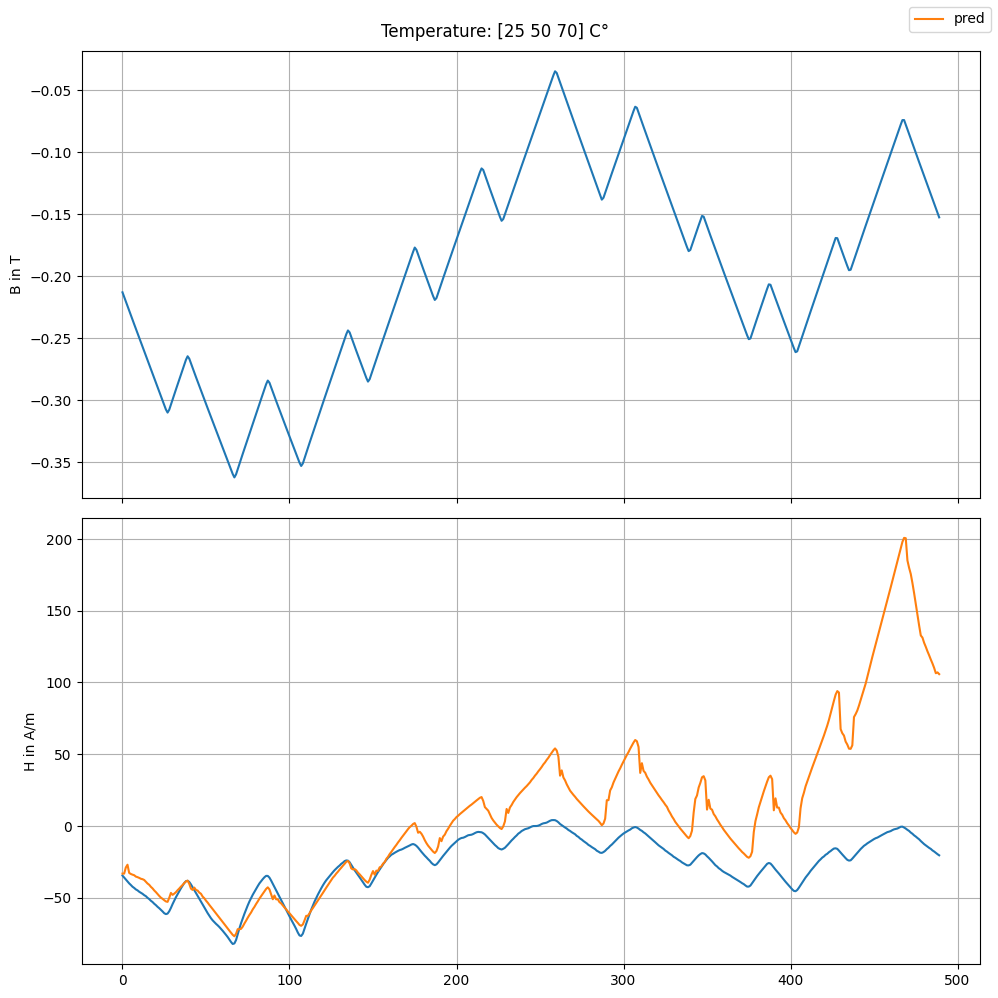

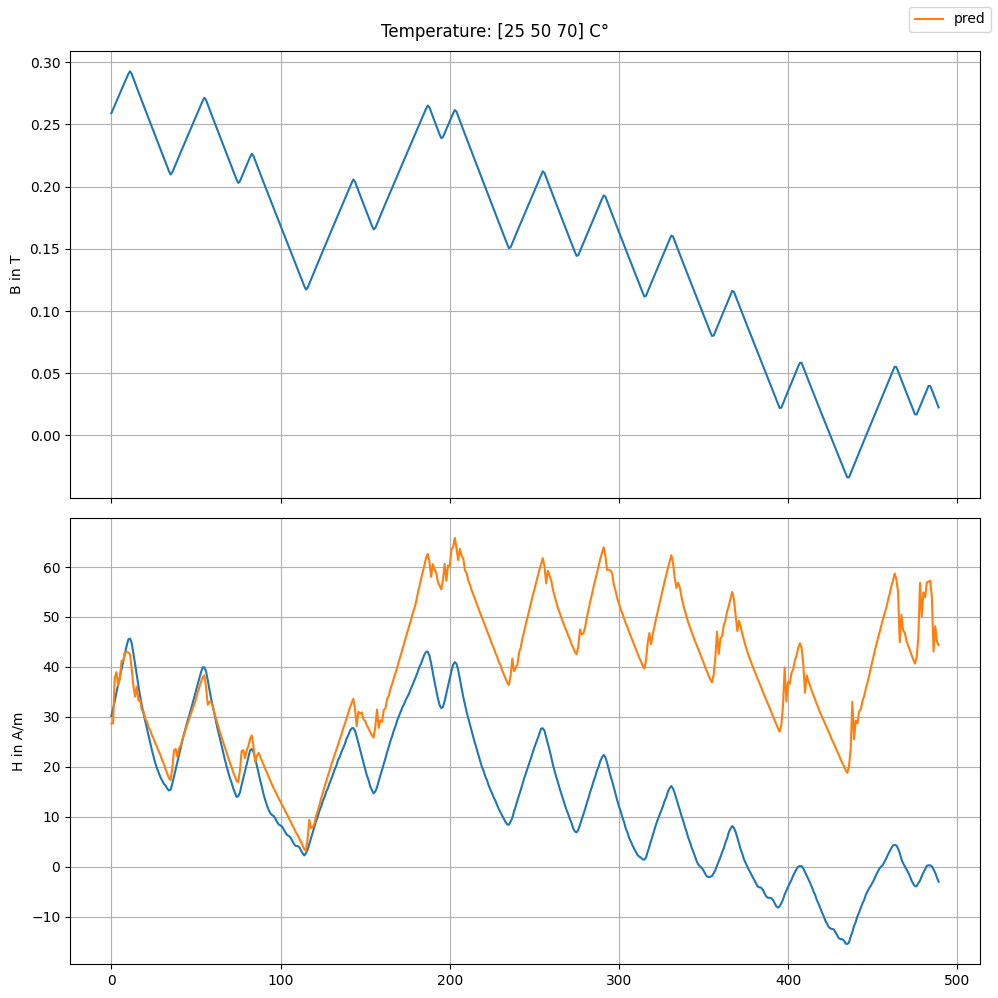

In [13]:
for H_p, H, B in zip(H_pred, data.H[:10, 10:500], data.B[:10, 10:500]):

    fig, axs = plot_single_sequence(B, H, jnp.unique(data.T))
    axs[-1].plot(H_p, label="pred")
    fig.legend()
    plt.show()

In [14]:
with open(EXPERIMENT_LOGS_ROOT / "jax_experiments" / f"{exp_id}.json") as f:
    exp_results = json.load(f)

In [15]:
exp_results

{'params': {'training_params': {'n_steps': 5000,
   'val_every': 1000,
   'tbptt_size': 64,
   'past_size': 1,
   'batch_size': 512},
  'model_params': {'obs_dim': 1,
   'state_dim': 20,
   'action_dim': 5,
   'width_size': 64,
   'depth': 2,
   'obs_func_type': 'identity',
   'key': [3594430910, 1784718894]},
  'lr_params': {'init_value': 0.001,
   'transition_steps': 1000000,
   'transition_begin': 2000,
   'decay_rate': 0.1,
   'end_value': 0.0001}},
 'logs': {'material': '3C90',
  'loss_trends_train': [29.214902877807617,
   2.629075527191162,
   0.7754478454589844,
   0.4708399176597595,
   0.36545416712760925,
   0.279298335313797,
   0.22042545676231384,
   0.1743510514497757,
   0.14844617247581482,
   0.12381226569414139,
   0.11012525111436844,
   0.10083525627851486,
   0.08754198253154755,
   0.08020146936178207,
   0.0729747861623764,
   0.06754249334335327,
   0.06401634961366653,
   0.05962194502353668,
   0.054237883538007736,
   0.05019587650895119,
   0.04707406461238